### 二次元リストから生成

In [1]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

import pandas as pd

# 1 各行を一つのリストとして並べる

list = [
    [1, 100, 0.33, 'AAA', 'AAA100'], 
    [2, 200, 0.67, 'BBB', 'BBB200'], 
    [3, 300, 1, 'CCC', 'CCC300'], 
    [4, 400, 1.33, 'DDD', 'DDD400'], 
    [5, 500, 1.67, 'EEE', 'EEE500'], 
    [6, 600, 2, 'FFF', 'FFF600']
]

# 2 表に変換
# pd.DataFrame(list) : pandasのDataFrameで表に変換
df = pd.DataFrame(list)
# 行名・列名は自動で割り振られた番号になっている

# 3 行名の変更
df.index = ['row0', 'row1', 'row2', 'row3', 'row4', 'row5']

# 4 列名の変更
df.columns = ['col0', 'col1', 'col2', 'col3', 'col4']

df

# 1 各行を一つのリストとして並べる
list = [
[1, 100, 0.33, 'AAA', 'AAA100'], 
[2, 200, 0.67, 'BBB', 'BBB200'], 
[3, 300, 1, 'CCC', 'CCC300'], 
[4, 400, 1.33, 'DDD', 'DDD400'], 
[5, 500, 1.67, 'EEE', 'EEE500'], 
[6, 600, 2, 'FFF', 'FFF600']]


#2 表に変換(オプションで行列名を指定)
ind = ['row0', 'row1', 'row2', 'row3', 'row4', 'row5']
col = ['col0', 'col1', 'col2', 'col3', 'col4']

df = pd.DataFrame(list, index=ind, columns=col)


df

# 1 各行を一つのリストにする
list = [
['row0', 1, 100, 0.33, 'AAA', 'AAA100'], 
['row1', 2, 200, 0.67, 'BBB', 'BBB200'], 
['row2', 3, 300, 1, 'CCC', 'CCC300'], 
['row3', 4, 400, 1.33, 'DDD', 'DDD400'], 
['row4', 5, 500, 1.67, 'EEE', 'EEE500'], 
['row5', 6, 600, 2, 'FFF', 'FFF600'], ]

# 2 表に変換
df = pd.DataFrame(list)

# 3 列名を変更
df.columns = ['', 'col0', 'col1', 'col2', 'col3', 'col4']

# 4 行名となる列を指定
df = df.set_index('')

df

# 1 各行ごとのリストを作成

listA = [1, 100, 0.33, 'AAA', 'AAA100']
listB = [2, 200, 0.67, 'BBB', 'BBB200']
listC = [3, 300, 1, 'CCC', 'CCC300']
listD = [4, 400, 1.33, 'DDD', 'DDD400']
listE = [5, 500, 1.67, 'EEE', 'EEE500']
listF = [6, 600, 2, 'FFF', 'FFF600']

# 2 まとめて表に変換

df = pd.DataFrame([listA, listB, listC, listD, listE, listF])

# 3 行名の変更
df.index = ['row0', 'row1', 'row2', 'row3', 'row4', 'row5']

# 4 列名の変更
df.columns = ['col0', 'col1', 'col2', 'col3', 'col4']

df

,col0,col1,col2,col3,col4
row0,1,100,0.33,AAA,AAA100
row1,2,200,0.67,BBB,BBB200
row2,3,300,1.00,CCC,CCC300
row3,4,400,1.33,DDD,DDD400
row4,5,500,1.67,EEE,EEE500
row5,6,600,2.00,FFF,FFF600


In [2]:
cg_c_data = return_dict_summary_fixed()

In [3]:
x = cg_c_data["processes"]
y = cg_c_data["ICNVRT"]

In [4]:
cg_icnvrt_lr = ModelLog10(x, y, "CG", "ICNVRT")

In [5]:
cg_icnvrt_lr.calc_lr()

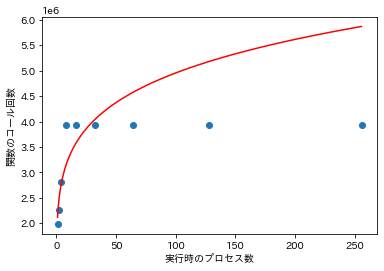

In [6]:
cg_icnvrt_lr.plot_graph()

In [7]:
max_in_y = max(y)
# 最大値の個数を取得
y.tolist().count(max_in_y)
# 最大値のインデックスで最小のもの
y.tolist().index(max_in_y)

3

In [8]:
class ModelBranch(ModelBase):
    
    def calc_lr(self):
        # 後述する t を算出するための処理
        max_in_train_y = max(self.train_y)
        max_in_train_y_first_index = self.train_y.tolist().index(max_in_train_y)
        # 分岐点のインデックスを t とする
        t = max_in_train_y_first_index
        self.t = t
        x_train_1 = self.train_x[:t]
        x_train_2 = self.train_x[t:]
        y_train_1 = self.train_y[:t]
        y_train_2 = self.train_y[t:]
        print(f"x_train1 = {x_train_1}, x_train2 = {x_train_2}")
        print(f"y_train1 = {y_train_1}, y_train2 = {y_train_2}")
        self.lr1 = LinearRegression()
        self.lr1.fit(x_train_1, y_train_1)
        self.lr2 = LinearRegression()
        self.lr2.fit(x_train_2, y_train_2)
        print(len(self.x_model_line))
        
    def calc_mape_score(self):
        x_test = self.test_x
        y_test = self.test_y
        y_test_predicted = self.lr2.predict(x_test)
        print(f"y_test = {y_test.tolist()}")
        print(f"y_test_predicted = {y_test_predicted.tolist()}")
        self.mape_score = float(mape_score(y_test, y_test_predicted))
        
    def plot_graph(self):
        plt.figure()
        plt.scatter(self.raw_x, self.raw_y)
        
        # 回帰曲線を二つのモデルで分割するための処理
        x_model_line = self.x_model_line
        t_in_model_line = 0
        for i in range(len(x_model_line)):
            if (self.train_x[self.t] < x_model_line[i]):
                t_in_model_line = i
                break
            else:
                t_in_model_line = i
        
        x_model_line1 = self.x_model_line[:t_in_model_line]
        x_model_line2 = self.x_model_line[t_in_model_line:]
        y_model_line1 = self.lr1.predict(x_model_line1)
        y_model_line2 = self.lr2.predict(x_model_line2)

        plt.plot(x_model_line1, y_model_line1, color="red")
        plt.plot(x_model_line2, y_model_line2, color="red")
        plt.plot(self.test_x, self.test_y, color="yellow")
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        

In [9]:
model_branch = ModelBranch(x, y, "CG", "ICNVRT")

In [10]:
model_branch.calc_lr()

x_train1 = [[1]
 [2]
 [4]], x_train2 = [[ 8]
 [16]
 [32]
 [64]]
y_train1 = [[1984770.]
 [2263540.]
 [2821070.]], y_train2 = [[3936140.]
 [3936140.]
 [3936140.]
 [3936140.]]
1024


In [11]:
model_branch.calc_mape_score()

y_test = [[3936140.0], [3936140.0]]
y_test_predicted = [[3936140.0], [3936140.0]]


In [12]:
model_branch.mape_score

0.0

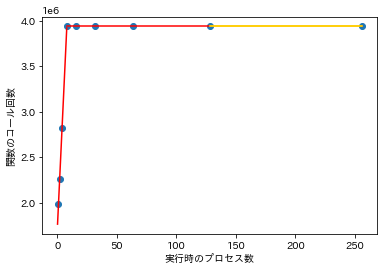

In [13]:
model_branch.plot_graph()